In [1]:
import os
import json
import pandas as pd
import datetime
import pprint

# Merge Datasets
We want to merge 2 datasets, gm_history.csv and trades.json, to get a list of trades between GMs

To do this, we will loop through all trades extracted in trades.json, and append the GMs for each team at the date the trade happened.

#### 1. Read in datasets

In [2]:
path = os.getcwd()
path = os.path.abspath(os.path.join(path, os.pardir, 'data/trades.json'))
with open(path) as f:
    trades = json.load(f)
    
path = os.getcwd()
path = os.path.abspath(os.path.join(path, os.pardir, 'data/gm_history.csv'))
with open(path) as f:
    df_gm_hist = pd.read_csv(f)

clean up trades dataset, replace 'Colorado Avalanch' with 'Colorado Avalanche'

In [3]:
count = 0
errors = 0
for year in trades:
    count += len(trades[year])
    for trade in trades[year]:
        if trade['team1'] == 'Colorado Avalanch':
            trade['team1'] = 'Colorado Avalanche'
            errors += 1
        if trade['team2'] == 'Colorado Avalanch':
            trade['team2'] = 'Colorado Avalanche'
            errors += 1
print('total errors fixed: ' + str(errors))
print('total trades: ' + str(count))

total errors fixed: 119
total trades: 2210


clean up df_gm_hist to recognize date types

In [4]:
df = df_gm_hist[['team', 'start_date', 'name']]
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df['start_date'] = pd.to_datetime(df['start_date'], format="%B %d, %Y", errors='coerce')

In [5]:
# pd.set_option("display.max_rows", None, "display.max_columns", None)
# df

#### 2. Merge dataset (create new dataset where for each trade, team data is replaced by team GMs)

In [6]:
for year in trades:
    for trade in trades[year]:
        date = datetime.datetime.strptime(trade['date'], '%d%b%Y')
        try:
            gm_1 = df[ (df['team']==trade['team1']) & (df['start_date'] < date) ].iloc[-1]['name']
            gm_2 = df[ (df['team']==trade['team2']) & (df['start_date'] < date) ].iloc[-1]['name']
            trade['team1_gm'] = gm_1
            trade['team2_gm'] = gm_2
        except Exception:
            pprint.pprint(trade)

    #     print(date)
    #     print(trade['team1'] + ': ' + gm_1)
    #     print(trade['team2'] + ': ' + gm_2)
    #     print('\n\n')
    
# save to json file in data directory
path = os.getcwd()
path = os.path.abspath(os.path.join(path, os.pardir, 'data/trades_and_gms.json'))
with open(path, 'w') as f:
        json.dump(trades, f, indent=2)

In [7]:
# for trade in trades['2014-15']:
#     print(trade['date'])
#     print(trade['team1_gm'])
#     print(trade['team2_gm'])
#     print()

#### 3. Create Knowledge Graph

In [8]:
import networkx as nx

In [9]:
G = nx.MultiGraph()
for trade in trades['2019-20']:
    G.add_edge(trade['team1_gm'], trade['team2_gm'])
for trade in trades['2020-21']:  
    G.add_edge(trade['team1_gm'], trade['team2_gm'])
    print(trade['date'] + ': ' + trade['team1_gm'] + ' and ' + trade['team2_gm'] )

09Oct2020: Kevin Cheveldayoff and Kelly McCrimmon
08Oct2020: Jarmo Kekalainen and Bill Zito
08Oct2020: Pierre Dorion and Bob Murray
08Oct2020: Tom Fitzgerald and Jarmo Kekalainen
07Oct2020: Pierre Dorion and Jim Rutherford
07Oct2020: Bill Guerin and David Poile
07Oct2020: Rob Blake and Jeff Gorton
06Oct2020: Marc Bergevin and Jarmo Kekalainen
05Oct2020: Doug Wilson and Bill Guerin
04Oct2020: Stan Bowman and Rob Blake
02Oct2020: Pierre Dorion and Bill Zito
28Sep2020: Stan Bowman and Kelly McCrimmon
26Sep2020: Steve Yzerman and Jeff Gorton
24Sep2020: Jim Rutherford and Bill Zito
16Sep2020: Bill Guerin and Kevyn Adams
12Sep2020: Marc Bergevin and Don Waddell
11Sep2020: Bill Guerin and Jim Rutherford
02Sep2020: Marc Bergevin and Doug Armstrong
25Aug2020: Jim Rutherford and Kyle Dubas


In [10]:
G.nodes

NodeView(('Lou Lamoriello', 'Pierre Dorion', 'Don Waddell', 'Dale Tallon', 'Ken Holland', 'Steve Yzerman', 'Jeff Gorton', 'Tom Fitzgerald', 'Julien BriseBois', 'Doug Wilson', 'Kelly McCrimmon', 'Stan Bowman', 'Jim Rutherford', 'Jason Botterill', 'Joe Sakic', 'Chuck Fletcher', 'Marc Bergevin', 'Kyle Dubas', 'Bob Murray', 'Don Sweeney', 'Brad Treliving', 'Rob Blake', 'Jim Nill', 'Jarmo Kekalainen', 'Jim Benning', 'David Poile', 'Brian MacLellan', 'John Chayka', 'Kevin Cheveldayoff', 'Doug Armstrong', 'Bill Guerin', 'Ray Shero', 'Paul Fenton', 'Bill Zito', 'Kevyn Adams'))

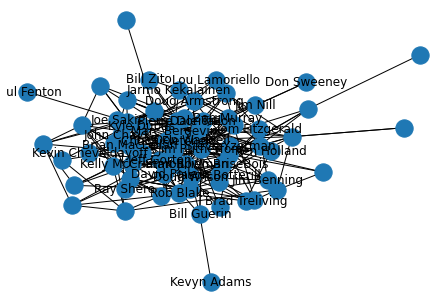

In [11]:
nx.draw(G, with_labels=True)
nx.draw(G)

In [12]:
g = nx.MultiGraph()
g.add_edge(1,2)
g.add_edge(1,3)
g.add_edge(1,2)


1

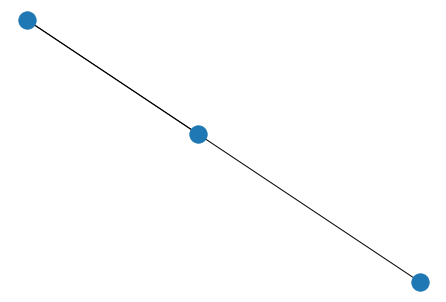

In [13]:
nx.draw(g)

#### 3.1 Use ipycytoscape

In [14]:
import ipycytoscape
import ipywidgets as widgets

In [15]:
# undirected = ipycytoscape.CytoscapeWidget()
# undirected.graph.add_graph_from_networkx(G)
# display(undirected)

In [16]:
# G2 = nx.Graph()
# G2.add_node('separate node 1')
# G2.add_node('separate node 2')
# G2.add_edge('separate node 1', 'separate node 2')
# undirected.graph.add_graph_from_networkx(G2)

##### 3.1.1 Convert data to necessary JSON format
define functions ⬇️

In [17]:
def flatten_data(data):
    '''Return a list of trades, omitting season specifier'''
    trades = []
    for year in data:
        trades.extend([trade for trade in data[year]])
    return trades

def return_trades_since_date(data, date_str):
    '''date needs to be in format ddbbbYYYY -> date format string == '%d%b%Y'
        ex. date_str = 12Apr2021'''
    date_compare = datetime.datetime.strptime(date_str, '%d%b%Y')
    trades = [trade for trade in data if datetime.datetime.strptime(trade['date'], '%d%b%Y') >= date_compare]
    return trades

def return_trades_for_team(data, team_str):
    '''Returns trades matching a team name'''
    return [trade for trade in data if (trade['team1']==team_str or trade['team2']==team_str)]

def return_trades_for_gm(data, gm_str):
    '''Returns trades matching a team name'''
    return [trade for trade in data if (trade['team1_gm']==gm_str or trade['team2_gm']==gm_str)]

def return_team_nodes(data):
    '''Returns nodes using team names in necessary ipycytoscape JSON format'''
    teams = set()
    for trade in data:
        teams.add(trade['team1'])
        teams.add(trade['team2'])
        
    nodes = [({ 'data': { 'id': team, 'name': team.split()[-1] } }) for team in teams]
    return nodes

def return_team_edges(data):
    '''Returns edges using team names in necessary ipycytoscape JSON format'''
    edges = []
    for trade in data:
        edges.append({'data': { 'source': trade['team1'], 'target': trade['team2']}})
    return edges

def return_gm_nodes(data):
    '''Returns nodes using gm names in necessary ipycytoscape JSON format'''
    gms = set()
    for trade in data:
        gms.add(trade['team1_gm'])
        gms.add(trade['team2_gm'])
        
    nodes = [({ 'data': { 'id': gm, 'name': gm } }) for gm in gms]
    return nodes

def return_gm_edges(data):
    '''Returns edges using gm names in necessary ipycytoscape JSON format'''
    edges = []
    for trade in data:
        edges.append({'data': { 'source': trade['team1_gm'], 'target': trade['team2_gm']}})
    return edges

example of function usage ⬇️

In [18]:
trades_flattened = flatten_data(trades)
trades_since_date = return_trades_since_date(trades_flattened, '16Jul2019')
trades_chicago = return_trades_for_team(trades_since_date, 'Chicago Blackhawks')
trades_waddell = return_trades_for_gm(return_trades_since_date(trades_flattened, '01Jan2000'), 'Don Waddell')
nodes_team = return_team_nodes(trades_since_date)
edges_team = return_team_edges(trades_since_date)
nodes_gm = return_gm_nodes(trades_since_date)
edges_gm = return_gm_edges(trades_since_date)
# pprint.pprint(trades_waddell)
# trades_since_date[0:2]

##### 3.2 Create Knowledge Graph of Trades Between Clubs

In [19]:
# get data in correct format
trades_flattened = flatten_data(trades)
trades_since_date = return_trades_since_date(trades_flattened, '01Jul2021')
nodes = return_team_nodes(trades_since_date)
edges = return_team_edges(trades_since_date)
data = {
    'nodes': nodes,
    'edges': edges
}

cytoscapeobj = ipycytoscape.CytoscapeWidget()
cytoscapeobj.graph.add_graph_from_json(data)

cytoscapeobj.set_style([{
                        'selector': 'node',
                        'css': {
                            'content': 'data(name)',
                            'text-valign': 'center',
                            'color': 'white',
                            'text-outline-width': 2,
                            'text-outline-color': 'green',
                            'background-color': 'green'
                        }
                        },
                        {
                        'selector': ':selected',
                        'css': {
                            'background-color': 'black',
                            'line-color': 'black',
                            'target-arrow-color': 'black',
                            'source-arrow-color': 'black',
                            'text-outline-color': 'black'
                        }}
                        ])

display(cytoscapeobj)

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'css': {'content': 'd…

##### 3.3 Create Knowledge Graph of Trades Between General Managers

In [20]:
# get data in correct format
trades_flattened = flatten_data(trades)
trades_since_date = return_trades_since_date(trades_flattened, '01Jul2021')
nodes = return_gm_nodes(trades_since_date)
edges = return_gm_edges(trades_since_date)
data = {
    'nodes': nodes,
    'edges': edges
}

cytoscapeobj = ipycytoscape.CytoscapeWidget()
cytoscapeobj.graph.add_graph_from_json(data)

cytoscapeobj.set_style([{
                        'selector': 'node',
                        'css': {
                            'content': 'data(name)',
                            'text-valign': 'center',
                            'color': 'white',
                            'text-outline-width': 2,
                            'text-outline-color': 'green',
                            'background-color': 'green'
                        }
                        },
                        {
                        'selector': ':selected',
                        'css': {
                            'background-color': 'black',
                            'line-color': 'black',
                            'target-arrow-color': 'black',
                            'source-arrow-color': 'black',
                            'text-outline-color': 'black'
                        }}
                        ])

display(cytoscapeobj)

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'css': {'content': 'd…

##### 3.4 Create Knowledge Graph of Trades By a Single Team
Chicago Blackhawks

In [21]:
# get data in correct format
trades_flattened = flatten_data(trades)
trades_since_date = return_trades_since_date(trades_flattened, '01Jul2015')
trades_chicago = return_trades_for_team(trades_since_date, 'Chicago Blackhawks')
nodes = return_team_nodes(trades_chicago)
edges = return_team_edges(trades_chicago)
data = {
    'nodes': nodes,
    'edges': edges
}

cytoscapeobj = ipycytoscape.CytoscapeWidget()
cytoscapeobj.graph.add_graph_from_json(data)

cytoscapeobj.set_style([{
                        'selector': 'node',
                        'css': {
                            'content': 'data(name)',
                            'text-valign': 'center',
                            'color': 'white',
                            'text-outline-width': 2,
                            'text-outline-color': 'red',
                            'background-color': 'red'
                        }
                        },
                        {
                        'selector': ':selected',
                        'css': {
                            'background-color': 'black',
                            'line-color': 'black',
                            'target-arrow-color': 'black',
                            'source-arrow-color': 'black',
                            'text-outline-color': 'black'
                        }}
                        ])
print('Chicago Blackhawks Trades since 01Jul2015')
display(cytoscapeobj)

Chicago Blackhawks Trades since 01Jul2015


CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'css': {'content': 'd…

Carolina Hurricanes

In [22]:
# get data in correct format
trades_flattened = flatten_data(trades)
trades_since_date = return_trades_since_date(trades_flattened, '01Jul2015')
trades_chicago = return_trades_for_team(trades_since_date, 'Carolina Hurricanes')
nodes = return_team_nodes(trades_chicago)
edges = return_team_edges(trades_chicago)
data = {
    'nodes': nodes,
    'edges': edges
}

cytoscapeobj = ipycytoscape.CytoscapeWidget()
cytoscapeobj.graph.add_graph_from_json(data)

cytoscapeobj.set_style([{
                        'selector': 'node',
                        'css': {
                            'content': 'data(name)',
                            'text-valign': 'center',
                            'color': 'white',
                            'text-outline-width': 2,
                            'text-outline-color': 'red',
                            'background-color': 'black'
                        }
                        },
                        {
                        'selector': ':selected',
                        'css': {
                            'background-color': 'black',
                            'line-color': 'black',
                            'target-arrow-color': 'black',
                            'source-arrow-color': 'black',
                            'text-outline-color': 'black'
                        }}
                        ])
print('Carolina Hurricanes Trades since 01Jul2015')
display(cytoscapeobj)

Carolina Hurricanes Trades since 01Jul2015


CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'css': {'content': 'd…

##### 3.5 Create Knowledge Graph of Trades By a General Manager

In [23]:
# get data in correct format
trades_flattened = flatten_data(trades)
trades_since_date = return_trades_since_date(trades_flattened, '01Jan2000')
trades_waddell = return_trades_for_gm(trades_since_date, 'Don Waddell')
nodes = return_team_nodes(trades_waddell)
edges = return_team_edges(trades_waddell)
data = {
    'nodes': nodes,
    'edges': edges
}

cytoscapeobj = ipycytoscape.CytoscapeWidget()
cytoscapeobj.graph.add_graph_from_json(data)

cytoscapeobj.set_style([{
                        'selector': 'node',
                        'css': {
                            'content': 'data(name)',
                            'text-valign': 'center',
                            'color': 'white',
                            'text-outline-width': 2,
                            'text-outline-color': 'red',
                            'background-color': 'black'
                        }
                        },
                        {
                        'selector': ':selected',
                        'css': {
                            'background-color': 'black',
                            'line-color': 'black',
                            'target-arrow-color': 'black',
                            'source-arrow-color': 'black',
                            'text-outline-color': 'black'
                        }}
                        ])
print('Don Waddell All Time Trades')
display(cytoscapeobj)


Don Waddell All Time Trades


CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'css': {'content': 'd…

In [24]:
# get data in correct format
trades_flattened = flatten_data(trades)
trades_since_date = return_trades_since_date(trades_flattened, '01Jan2000')
trades_francis = return_trades_for_gm(trades_since_date, 'Ron Francis')
nodes = return_gm_nodes(trades_francis)
edges = return_gm_edges(trades_francis)
data = {
    'nodes': nodes,
    'edges': edges
}

cytoscapeobj = ipycytoscape.CytoscapeWidget()
cytoscapeobj.graph.add_graph_from_json(data)

cytoscapeobj.set_style([{
                        'selector': 'node',
                        'css': {
                            'content': 'data(name)',
                            'text-valign': 'center',
                            'color': 'white',
                            'text-outline-width': 2,
                            'text-outline-color': 'navy',
                            'background-color': 'black'
                        }
                        },
                        {
                        'selector': ':selected',
                        'css': {
                            'background-color': 'teal',
                            'line-color': 'black',
                            'target-arrow-color': 'black',
                            'source-arrow-color': 'black',
                            'text-outline-color': 'black'
                        }}
                        ])
print('Don Waddell All Time Trades')
display(cytoscapeobj)

Don Waddell All Time Trades


CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'css': {'content': 'd…